## VGG-19预训练模型应用

In [1]:
import tensorflow.keras.applications.vgg19 as vgg19
import tensorflow.keras.preprocessing.image as imagepre

# 加载预训练模型
model = vgg19.VGG19(weights='E:\\MLDatas\\vgg19_weights_tf_dim_ordering_tf_kernels.h5', include_top=True)
# 加载图片并转换为合适的数据形式
image = imagepre.load_img('116.jpg', target_size=(224, 224))
imagedata = imagepre.img_to_array(image)
imagedata = imagedata.reshape((1,) + imagedata.shape)

imagedata = vgg19.preprocess_input(imagedata)
prediction = model.predict(imagedata) # 分类预测
results = vgg19.decode_predictions(prediction, top=3)
print(results)

40960/35363 [==================================] - 0s 7us/step
[[('n02113624', 'toy_poodle', 0.6034096), ('n02113712', 'miniature_poodle', 0.3442649), ('n02113799', 'standard_poodle', 0.0124355825)]]


## 以下为第九章的FGSM对抗样本攻击示例 

In [3]:
import tensorflow as tf
import tensorflow.keras as keras

loss_object = keras.losses.CategoricalCrossentropy()
# 计算梯度
def compute_grad(input_image, input_label):
    with tf.GradientTape() as g:
        g.watch(tensor=input_image) # 将输入样本作为要计算梯度的变量
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    gradient = g.gradient(loss, input_image) # 求损失函数的梯度
    return gradient

In [4]:
gradients = compute_grad(tf.constant(imagedata), prediction)

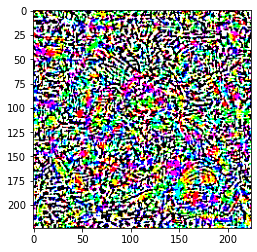

In [5]:
perturbations = tf.sign(gradients) # 梯度的符号作为扰动

import matplotlib.pyplot as plt
plt.imshow(imagepre.array_to_img((perturbations.numpy()[0])[:,:,[2,1,0]]))

[[('n02113712', 'miniature_poodle', 0.38657865), ('n02113624', 'toy_poodle', 0.1982371), ('n02108551', 'Tibetan_mastiff', 0.07516186)]]


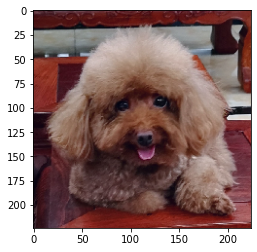

In [6]:
import numpy as np
# 加扰动，显示扰动后的预测和对抗样本图
epsilon = 0.35
adv_x = imagedata + epsilon * perturbations.numpy()
img_predict = model.predict([adv_x], batch_size=None)
print(vgg19.decode_predictions(img_predict, top=3))
plt.imshow(imagepre.array_to_img((adv_x[0])[:,:,[2,1,0]]))

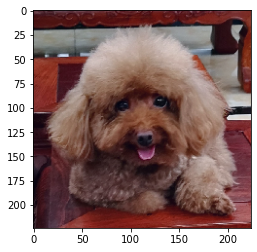

In [7]:
# 显示原图进行对比
plt.imshow(imagepre.array_to_img((imagedata[0])[:,:,[2,1,0]]))

##### 定向攻击 

In [10]:
taget_label = np.zeros(1000) 
taget_label[244] = 1.0 # 攻击目标设为藏獒

In [13]:
taget_label = taget_label.reshape(1, 1000)

In [14]:
e = 0.01
adv = imagedata
for i in range(1000):
    gradients = compute_grad(tf.constant(adv), taget_label)
    perturbations = tf.sign(gradients)
    adv = adv - e * perturbations
    adv_predict = model.predict([adv], batch_size=None)
    print(i, ':', np.argmax(adv_predict))
    if np.argmax(adv_predict) == np.argmax(taget_label):
        break

0 : 265
1 : 265
2 : 265
3 : 265
4 : 265
5 : 265
6 : 265
7 : 265
8 : 265
9 : 265
10 : 265
11 : 265
12 : 265
13 : 265
14 : 265
15 : 265
16 : 265
17 : 265
18 : 265
19 : 265
20 : 265
21 : 266
22 : 266
23 : 266
24 : 266
25 : 266
26 : 266
27 : 266
28 : 266
29 : 266
30 : 266
31 : 266
32 : 266
33 : 266
34 : 244


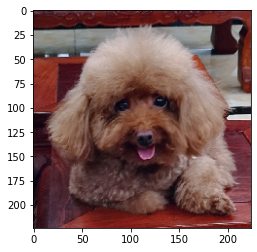

In [15]:
# 显示定向攻击成功后的图片
plt.imshow(imagepre.array_to_img((adv.numpy()[0])[:,:,[2,1,0]]))